## Training Transformer Models for Text Classification

In [ ]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Hugging Face Dataset

To load the Hugging Face "emotion" dataset efficiently, use the `load_dataset()` function from the `datasets` library, specifying the dataset by name. The most widely used version on the Hugging Face Hub is `"dair-ai/emotion"`.

In [ ]:
from datasets import load_dataset

# Load the dataset
emotions_set = load_dataset("dair-ai/emotion")
display(emotions_set)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

The `emotions_set` object behaves like a Python dictionary, with each key representing a data split *(such as `'train'`, `'validation'`, or `'test'`)*, and you can access any split using standard dictionary indexing, for example `emotions_set['train']`.

In [ ]:
train_dataset = emotions_set["train"]
display(train_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

The split we accessed is an instance of the `Dataset` class, one of the core data structures in the Datasets library. For now, you can think of a `Dataset` as behaving much like a standard Python list: for example, you can query its length with `len(dataset)` to see how many examples it contains.

In [ ]:
display(len(train_dataset))

16000

A `Dataset` also supports integer indexing, so you can retrieve a single example by its position, for example `dataset[0]` to get the first record.

In [ ]:
display(train_dataset[0])

{'text': 'i didnt feel humiliated', 'label': 0}

A single row of a `Dataset` is returned as a Python dictionary, where each key is a column name and each value contains the corresponding data for that row.

In [ ]:
display(train_dataset.column_names)

['text', 'label']

In this dataset, the values are the tweet text and its associated emotion label. This layout reflects that the library is built on top of [Apache Arrow](https://arrow.apache.org/), which uses a typed, columnar memory format that is more efficient than native Python objects for large datasets. You can inspect the underlying column types by checking the `features` attribute of a `Dataset` object.

In [ ]:
print(train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In this dataset, the `text` column uses the `string` type, while the `label` column is stored as a `ClassLabel` feature that keeps track of the class names and their integer IDs. You can also retrieve multiple rows at once by using standard Python slicing, for example `dataset[0:5]` to access several consecutive examples.

In [ ]:
print(train_dataset[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


When you slice a `Dataset`, the dictionary values become lists of elements rather than single items, since each key now holds a batch of rows. You can also retrieve an entire column at once by passing its name, for example `dataset["text"]` to get all tweet texts.

In [ ]:
print(train_dataset["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


#### Exercise 1: Dataset Exploration

1. Browse the [Hugging Face Datasets Hub](https://huggingface.co/datasets) and find another text classification dataset (e.g., `imdb`, `ag_news`, or `yelp_review_full`). Load this dataset and explore its structure. How many classes does it have? How is it different from the emotion dataset?

A good example of another text classification dataset on the Hub is the IMDb movie reviews dataset. It contains 50,000 English reviews labeled for binary sentiment *(positive vs. negative)*, making it a standard benchmark for sentiment classification tasks.

Key differences from the emotion dataset
- **Label space:** IMDb predicts coarse sentiment polarity *(positive vs. negative)*, while the emotion dataset predicts one of six finer-grained emotions.

- **Domain:** IMDb consists of long-form movie reviews, whereas the emotion dataset contains short social media texts *(e.g., tweets)*.

- **Task type:** Both are text classification tasks, but IMDb is standard sentiment analysis, and the emotion dataset targets emotion recognition, which is often considered more fine-grained and nuanced.

In [ ]:
# Load the IMDb dataset from the Hub
imdb_set = load_dataset("imdb")
display(imdb_set)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Inspect the features (column names and types) of the train split
print(imdb_set["train"].features)

{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}


In [ ]:
# Check how many examples are in each split
print("Train size:", len(imdb_set["train"]))
print("Test size:", len(imdb_set["test"]))
print("Unsupervised size:", len(imdb_set["unsupervised"]))

Train size: 25000
Test size: 25000
Unsupervised size: 50000


In [ ]:
# Look at a single example
print(imdb_set["train"][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

2. The current dataset is imbalanced. Using the Pandas documentation, research and implement at least one strategy to handle class imbalance *(e.g., using `resample()` or `sample()` with weights)*. What effect do you expect this to have on model performance?

A straightforward way to address class imbalance in `dair-ai/emotion` is to randomly undersample the majority classes using `pandas.DataFrame.sample`, so that each label has a similar number of examples. 

In [ ]:
import pandas as pd

df = train_dataset.to_pandas()  # columns: 'text', 'label' (int)

# Map integer labels to human-readable names
label_names = train_dataset.features["label"].names
df["label_name"] = df["label"].map(dict(enumerate(label_names)))

# Check original class distribution
print(df["label_name"].value_counts())

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


In [ ]:
# Compute target size = size of smallest class
min_count = df["label_name"].value_counts().min()

# Undersample each class equally using groupby.sample()
df_undersampled = (
    df.groupby("label_name", group_keys=False)
      .sample(n=min_count, random_state=42)
)

# Check new class distribution
print(df_undersampled["label_name"].value_counts())

label_name
anger       572
fear        572
joy         572
love        572
sadness     572
surprise    572
Name: count, dtype: int64


This reduces the dominance of frequent emotions and encourages the model to pay more attention to rare classes, which typically improves recall and macro-averaged F1 for minority emotions such as *love* or *suprise*, because the decision boundary is no longer overwhelmed by majority samples.

However, undersampling discards a substantial portion of the majority-class data, which can remove useful information, leading to weaker performance on those frequent emotions and sometimes a drop in overall accuracy or micro-F1, especially if the original dataset was not very large.

#### Offline or Local Datasets (Not on the Hugging Face Hub)

Most examples in this notebook use datasets downloaded directly from the Hugging Face Hub, but in practice you’ll often work with files stored locally (on your laptop) or on a private server.

Datasets supports this via specialized loading scripts for common formats; we simply call `load_dataset()` with the appropriate builder (for example `"csv"`, `"json"`, or `"parquet"`) and pass a `data_files` argument pointing to one or more local paths or URLs. For instance, since the raw `dair-ai/emotion` data files live on Dropbox, we could bypass the Hub by downloading a split to disk and then loading it.

In [ ]:
import requests

url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
output_path = "train.txt"

r = requests.get(url)
r.raise_for_status()

with open(output_path, "wb") as f:
    f.write(r.content)

print("Download :", output_path)

Download : train.txt


In [ ]:
with open("train.txt", "r", encoding="utf-8") as f:
    first_line = f.readline()

print(first_line)

i didnt feel humiliated;sadness



The file has no column headers, and each tweet–emotion pair is separated by a semicolon. However, its structure is close enough to a CSV that we can load it locally with the CSV loader, simply by passing the `csv` script and setting `data_files` to point to `train.txt`.

In [ ]:
# Load the local dataset
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

Here, the delimiter and column names are explicitly specified. An even simpler option is to skip the local file altogether and pass the dataset URL directly to the `data_files` argument. This automatically downloads and caches the file for us.

#### From Datasets to DataFrames

Datasets offers powerful tools for slicing and transforming data, but it is often more convenient to convert a `Dataset` to a Pandas `DataFrame` to take advantage of higher-level analysis and visualization APIs. The `set_format()` method lets you change the output format of a Dataset (for example, to `"pandas"`), without altering the underlying storage format, which remains an Apache Arrow table and can be switched to a different format again later if needed.

In [ ]:
emotions_set.set_format(type="pandas")
df = emotions_set["train"][:]

display(df.head())

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The column names are preserved, and the first rows line up with what we saw before. Since the labels are still stored as integers, we can call the `int2str()` method of the label feature to add a new column to the `DataFrame` containing the corresponding label names.

In [ ]:
def label_int2str(row):
    return emotions_set["train"].features["label"].int2str(row)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
# Map integer labels to human-readable names
df["label_name"] = df["label"].apply(label_int2str)
display(df.head())

Before jumping into model building, it’s worth spending some time exploring the dataset in detail. As Andrej Karpathy emphasizes in his blog post [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/), truly understanding your data (“becoming one with the data”) is a crucial step toward training strong models.

#### Class Distribution

When working on text classification tasks, it is important to inspect how examples are distributed across classes. If the class distribution is highly skewed, you may need to adjust your choice of loss function and evaluation metrics compared to a balanced dataset. Using Pandas together with Matplotlib, you can quickly plot this class distribution to get an immediate visual impression of any imbalance.

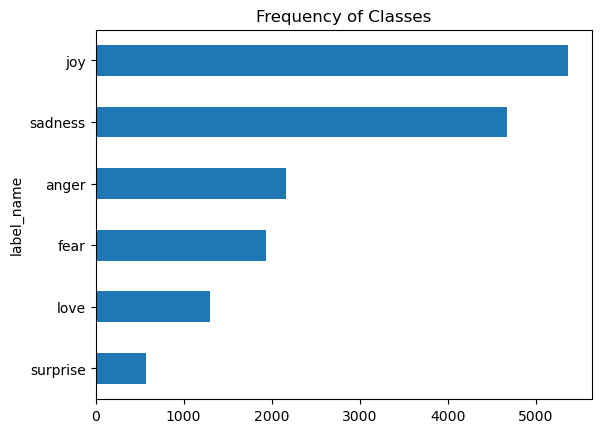

In [ ]:
import matplotlib.pyplot as plt

# Plot class distribution
class_counts = df["label_name"].value_counts(ascending=True)

plt.figure(figsize=(8, 5))
class_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Frequency of Classes", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In this dataset, the class distribution is strongly imbalanced: `joy` and `sadness` are very frequent, while `love` and `surprise` appear roughly 5–10 times less often. This kind of skew can be handled in several ways, but in this chapter we will keep the original, unbalanced class frequencies and train on them directly *(see Exercice 1)*.

Common strategies for imbalanced data include:
- Randomly oversampling minority classes.
- Randomly undersampling majority classes.
- Collecting more labeled examples for underrepresented classes.

To explore these techniques in more depth, you can look at the Imbalanced-learn library, which provides many resampling methods and utilities for imbalanced datasets.

When applying any sampling strategy, it is crucial to do it after creating your train/test (and validation) splits; otherwise, resampled examples can leak information across splits and lead to overly optimistic evaluation results.

#### Tweet Length Analysis

Transformer models have a maximum input sequence length, often called the **maximum context size**. For DistilBERT, this limit is 512 tokens, which corresponds to roughly a few paragraphs of text. In the next section, a **token** will be defined more precisely, but for now you can think of it roughly as a word. To approximate how long tweets are for each emotion, we can examine the distribution of word counts per tweet.

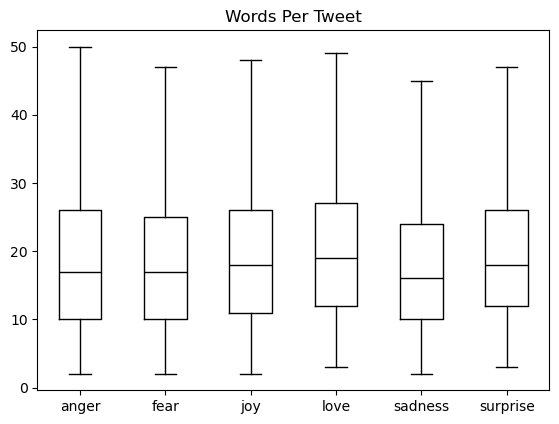

In [ ]:
# Plot boxplot of words per tweet by class
df["Words Per Tweet"] = df["text"].str.split().apply(len)

plt.figure(figsize=(8, 5))
df.boxplot(
    column="Words Per Tweet",
    by="label_name",
    grid=False,
    showfliers=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="red")
)

plt.title("Words per Tweet by Class", fontsize=14)
plt.suptitle("")  # Supprime le titre par défaut de pandas
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Words", fontsize=12)
plt.tight_layout()
plt.show()

The plot shows that, across all emotions, most tweets are roughly 15 words long, and even the longest tweets remain comfortably below DistilBERT’s maximum context window. When inputs exceed a model’s context size they must be truncated, which can hurt performance if important information is cut off. Here, the tweet lengths are short enough that truncation should not be a concern.

In [ ]:
# Reset dataset format to default
emotions_set.reset_format()

### From Text to Tokens

Transformer models such as DistilBERT do not process raw text directly, instead they require input that has been **tokenized** and **encoded** into numerical vectors. **Tokenization** refers to the process of dividing text into the fundamental units that the model can understand. Various tokenization strategies exist, and the optimal way of splitting words into smaller subunits is typically learned from the training corpus.

#### Character Tokenization

The most basic tokenization strategy is **character-level tokenization**, where each individual character is treated as a separate token. In Python, strings behave like sequences of characters, so a character-level tokenizer can be implemented very concisely by iterating directly over the string.

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)

print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a reasonable first step, but it is not yet in the form the model requires. The model expects each character token to be mapped to an integer ID, a process often referred to as **numericalization**. A simple way to achieve this is to assign a unique integer index to every distinct token (here, each character) in the vocabulary and then replace each character in the text with its corresponding index.

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


This defines a unique integer ID for every character in the vocabulary, and we can now use `token2idx` to convert the tokenized text into a sequence of integer IDs.

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Each token is now represented by a unique integer ID (hence the name `input_ids`). The next step is to convert these `input_ids` into a 2D tensor of one-hot vectors. One-hot encodings are a common way to represent categorical variables (whether ordinal or nominal) by assigning each category a distinct index and then representing it as a vector that is zero everywhere except at that index.

In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})

display(categorical_df)

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


This encoding scheme has a drawback: by assigning consecutive integers to categories, it implicitly introduces an artificial ordering among them, which neural networks are very good at exploiting even though it is meaningless. Instead, we can represent each category with its own binary feature, setting the value to 1 when the category is present and 0 otherwise. In Pandas, this one-hot representation can be created conveniently with the `get_dummies()` function.

In [ ]:
dummies = pd.get_dummies(categorical_df["Name"]).astype(int)
display(dummies)

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


Each row of this `DataFrame` is a one-hot vector, with exactly one position set to 1 (the “hot” entry) and all others set to 0. In contrast, the `input_ids` form an artificial ordinal scale: treating these IDs arithmetically (for example, by adding or subtracting them) is meaningless, because the resulting number is just another token ID with no numeric relationship to the originals.

Adding two one-hot vectors, by contrast, has an intuitive meaning: the positions with a value of 1 indicate which tokens are present, so their sum directly reflects co-occurrence. To build such one-hot encodings in PyTorch, you first convert `input_ids` to a tensor and then apply `torch.nn.functional.one_hot()` to obtain a 2D tensor of one-hot vectors for the sequence.

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

display(one_hot_encodings.shape)

torch.Size([38, 20])

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Our simple example illustrates that **character-level tokenization** disregards the inherent structure of text, interpreting it purely as a sequence of characters. While this approach can effectively handle misspellings and rare words, it forces the model to **learn higher-level linguistic structures**, such as words, directly from the data. This learning process demands substantial computational resources, memory, and data, which is why character-level tokenization is seldom used in practice.

#### Word Tokenization

Rather than splitting the text into individual characters, we can divide it into words and assign each word a unique integer. Starting with words allows the model to bypass the process of deriving words from characters, thereby simplifying and accelerating training.

A straightforward type of **word tokenizer** relies on whitespace to separate tokens. In practice, this can be done by applying Python’s `split()` function directly to the raw text, just as we did when measuring tweet lengths.  

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


From this point, we can follow the same procedure used for the character tokenizer to assign an ID to each word. However, this tokenization approach introduces a potential issue: it does not handle punctuation, meaning that a term like `NLP.` is treated as a single token. Moreover, since words may appear in various forms due to declensions, conjugations, or misspellings, the vocabulary size can quickly expand to millions of entries.  

A large vocabulary poses a significant challenge because it forces neural networks to maintain an enormous number of parameters. For example, imagine a model with one million unique words, where the first network layer reduces one-million-dimensional input vectors to one-thousand-dimensional representations. This common step in many NLP architectures would require a weight matrix containing 1 million × 1 thousand = 1 billion parameters, already comparable to the largest GPT-2 model which has approximately 1.5 billion parameters in total.  

Naturally, we want to avoid wasting model parameters, as training large models is both computationally expensive and difficult to maintain. A common solution is to restrict the vocabulary to a fixed size (for example, the 100,000 most frequent words in the corpus) and discard rarer ones. Words outside this limited vocabulary are replaced with a shared `UNK` token, representing “unknown.” However, this approach inevitably leads to some information loss, since the model cannot learn meaningful representations for the words mapped to `UNK`.  

#### Subword Tokenization

**Subword tokenization** aims to capture the advantages of both character- and word-level tokenization. Rare or complex words are split into smaller pieces so the model can still represent misspellings and infrequent forms, while common words are kept as single tokens to keep sequences short and efficient. Unlike simple rule-based splitting, these subword vocabularies are learned from a large pretraining corpus using statistical algorithms.

A widely used subword algorithm is WordPiece, employed by the BERT and DistilBERT tokenizers. In practice, you typically load such a tokenizer via a high-level `AutoTokenizer` interface by calling its `from_pretrained()` method with the identifier of a pretrained model (for example, the DistilBERT model you want to use), which automatically gives you the corresponding WordPiece tokenizer.

In [ ]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The `AutoTokenizer` class is part of a broader family of “auto” utilities that can automatically load the right configuration, weights, and vocabulary given just a checkpoint name, making it easy to swap models without changing much code. If you prefer, you can also instantiate the concrete tokenizer class directly instead of going through the auto interface. For DistilBERT, we could use `DistilBertTokenizerFast.from_pretrained(...)` to load the same tokenizer explicitly.

In [ ]:
#from transformers import DistilBertTokenizer
#distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

To see how this tokenizer behaves in practice, let’s apply it to our example sentence: *Tokenizing text is a core task of NLP.*

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


As with character-level tokenization, the tokenizer has mapped each token to a unique integer ID in the `input_ids` field. The purpose of the `attention_mask` field will be explained in the next section. Given these `input_ids`, we can recover the corresponding tokens by calling the tokenizer’s `convert_ids_to_tokens()` method.

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

We can notice three key details here. First, special tokens such as `[CLS]` and `[SEP]` have been added at the beginning and end of the sequence. Although the exact tokens vary across models, their primary purpose is to mark the sequence boundaries. Second, all tokens have been converted to lowercase, which is specific to this particular model checkpoint. Finally, words like “tokenizing” and “NLP” have been split into multiple tokens—an expected outcome since they are relatively uncommon. The `##` prefix in `##izing` and `##p` indicates that the token follows another without an intervening space, meaning it should be merged with the preceding token when reconstructing text. The `AutoTokenizer` class provides a `convert_tokens_to_string()` method to perform this reassembly automatically. 

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

The `AutoTokenizer` class also has several attributes that provide information about the tokenizer.

In [ ]:
# Display the vocabulary size
display(tokenizer.vocab_size)

In [ ]:
# Display the maximum model input length
display(tokenizer.model_max_length)

In [ ]:
# Display the model input names
display(tokenizer.model_input_names)

#### Tokenizing the Dataset

To tokenize the entire corpus, we will use the `map()` method of the `DatasetDict` object. This method will appear frequently throughout the notebook, as it offers a convenient way to apply a processing function to every element in a dataset. As we will see shortly, `map()` can also be used to generate new rows and columns within the dataset.  

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples. Setting `padding=True` pads each example with zeros to match the length of the longest sequence in the batch, while `truncation=True` ensures that sequences exceeding the model’s maximum context length are truncated accordingly.

In [ ]:
print(tokenize(emotions_set["train"][:2]))

Here, we can observe the effect of padding: since the first element of input_ids is shorter than the second, zeros have been added to match their lengths. These zeros correspond to the `[PAD]` token in the vocabulary, while the set of special tokens also includes the `[CLS]` and `[SEP]` tokens introduced earlier.  

In [ ]:
# Pair each special token with its corresponding ID
tokens_to_ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))

# Sort by token ID
data = sorted(tokens_to_ids, key=lambda x: x[-1])

# Create and display a DataFrame
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
display(df.T)

Note that, in addition to providing the encoded tweets as `input_ids`, the tokenizer also returns a list of `attention_mask` arrays. These masks prevent the model from being influenced by the padding tokens, ensuring that only the meaningful parts of each sequence are attended to. Within each batch, input sequences are padded to the length of the longest sequence, and the attention mask guides the model to disregard the padded regions during processing.

In [ ]:
emotions_encoded = emotions_set.map(tokenize, batched=True, batch_size=None)

By default, the `map()` method processes each example in the dataset individually. Setting batched=True enables batch processing, allowing the tweets to be encoded in groups. Since we have specified `batch_size=None`, the `tokenize()` function is applied to the entire dataset as a single batch. This approach ensures that the resulting input tensors and attention masks have consistent shapes across the dataset, and it also adds new `input_ids` and `attention_mask` columns to the dataset.  

In [ ]:
print(emotions_encoded["train"].column_names)

### Training a Text Classifier

The process begins by tokenizing the text and representing it as one-hot vectors, known as **token encodings**. The dimensionality of these encodings is determined by the size of the tokenizer’s vocabulary, which typically ranges from 20,000 to 200,000 unique tokens. These token encodings are then transformed into token embeddings—dense vectors situated in a lower-dimensional space. The **embeddings** are passed through the encoder block layers, producing a hidden state for each input token. During pretraining for language modeling, each hidden state is used to predict the masked tokens. For **classification tasks**, however, the language modeling head is replaced with a classification layer.  

We have two main strategies for training this type of model on our Twitter dataset:

- **Feature extraction:** Use the hidden states as fixed feature representations and train a separate classifier on top of them, leaving the pretrained model unchanged.  
- **Fine-tuning:** Train the entire model end-to-end, allowing the parameters of the pretrained model to be updated during training.  

In the following sections, we’ll explore both approaches using DistilBERT and discuss the trade-offs between them.  


#### Transformers as Feature Extractors

Using a transformer as a **feature extractor** is straightforward: we freeze the model’s body during training and use its **hidden states** as input features for a classifier. This approach allows for training smaller or shallower models efficiently. The classifier can be a simple neural layer or even a non-gradient-based method, such as a random forest. Moreover, this method is particularly practical when GPUs are unavailable, since the hidden states only need to be computed once.

We will make use of another convenient auto class from the Transformers library, called `AutoModel`. Like `AutoTokenizer`, it provides a `from_pretrained()` method that loads the weights of a pretrained model. 

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

#### Exercise 2: Tokenization Experiments

1. Load a different pre-trained model tokenizer (`bert-base-cased` or `roberta-base`) and compare its tokenization output with DistilBERT.  Use the [Hugging Face Models Hub](https://huggingface.co/models) to find available models. What differences do you notice? How does cased vs uncased tokenization affect the output?

In [ ]:
# Load the tokenizers
distilbert_tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tok    = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
sample_text = "Tokenizing NLP with DistilBERT and RoBERTa is Fun!"

print("DistilBERT:", distilbert_tok.tokenize(sample_text))
print("RoBERTa:  ", roberta_tok.tokenize(sample_text))

For this sentence, DistilBERT and RoBERTa differ in how they split words, how they mark subwords, and how they handle whitespace and casing.

- DistilBERT uses **WordPiece** with `##` to mark subword continuations, producing tokens such as `['token', '##izing']`, `['nl', '##p']`, and `['di', '##sti', '##lbert']`.

- RoBERTa uses **byte‑level BPE** and a special `Ġ` prefix to mark tokens that start with a space, yielding tokens like `['Token', 'izing']` , `['ĠN', 'LP']`, `['ĠDist', 'il', 'BER', 'T']`, and `['ĠRo', 'BER', 'Ta']`.

DistilBERT’s output is more “word‑like” with clear base‑plus‑suffix structure, whereas RoBERTa’s output reflects finer‑grained byte‑level splits and explicit whitespace markers.

Cased vs uncased tokenization also has a clear effect on the outputs.

- A **cased tokenizer** like RoBERTa preserves capitalization, so `Token` vs `token` or `Fun` vs `fun` become different tokens, allowing the model to leverage case as a signal (e.g. for acronyms, proper nouns, or emphasis).

- An **uncased tokenizer** like DistilBERT maps different casing variants to the same subword pieces, which reduces vocabulary sparsity and is robust to noisy casing, but discards any information that is encoded purely by capitalization.

2.  Experiment with the tokenizer's `padding` and `truncation` parameters. What happens if you set `max_length=10` with `truncation=True`? Read the [tokenizer documentation](https://huggingface.co/docs/transformers/main_classes/tokenizer) to understand different padding strategies (`max_length`, `longest` or `do_not_pad`).

In [ ]:
# 
enc = tokenizer(
    sample_text,
    max_length=10,
    truncation=True,
    padding="max_length",
)

print(tokenizer.convert_ids_to_tokens(enc.input_ids))

When `max_length=10` and `truncation=True` are set, any encoded sequence longer than 10 tokens is cut so that its final length is exactly 10 tokens, including any special tokens the tokenizer adds. Shorter sequences can then be padded depending on the chosen padding strategy.

- Any sequence whose encoded length exceeds 10 tokens is truncated down to 10 tokens.

- With `padding="max_length"`, all shorter sequences are padded with the pad token up to length 10, so every `input_ids` vector has length 10.

**Padding strategies**

- `padding="max_length"`

    - Always pads each sequence to `max_length` (or to the model’s built‑in maximum if `max_length` is not provided).

    - With `max_length=10`, all sequences end up with length 10, regardless of how long they were originally.

- `padding="longest"` or `padding=True`

    - In each batch, pads sequences only up to the length of the longest encoded example in that batch.

    - If `max_length=10` and `truncation=True` are also set, the longest sequence in the batch is at most 10 tokens, and shorter ones are padded up to that length (≤ 10).

- `padding="do_not_pad"` or `padding=False`

    - No padding is added; each sequence keeps its own length after truncation.

    - With `max_length=10` and `truncation=True`, all sequences have length at most 10, but lengths can differ between sequences, so they cannot be stacked into a single rectangular batch tensor without further processing.

#### Interoperability between Frameworks

Transformers is primarily demonstrated with PyTorch in this notebook, but it also integrates seamlessly with TensorFlow and JAX. In practice, only a few lines of code need to be modified to load and use a pretrained model in your preferred deep learning framework.

In [ ]:
from transformers import TFAutoModel

model_ckpt = "bert-base-uncased"
tf_model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True)

This interoperability becomes particularly handy when a model is released in only one framework but you want to use it in another, such as with the **XLM-RoBERTa** model. In such cases, you can pass `from_pt=True` to `TFAutoModel.from_pretrained()`, and the library will automatically download the PyTorch checkpoint and convert the weights to TensorFlow for you.

In [ ]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

Switching between frameworks in Transformers is straightforward. In most cases, you can obtain the TensorFlow 2.0 equivalents simply by adding a `TF` prefix to the PyTorch class names. Likewise, when a configuration or method expects the string `"pt"` (for PyTorch), you can usually replace it with `"tf"` to select the TensorFlow variant instead.

#### Extracting the Hidden States

To begin, retrieve the **last hidden states** for a single input string. First encode the string and convert the resulting tokens into PyTorch tensors by passing `return_tensors="pt"` to the tokenizer.

In [ ]:
text = "this is a test"

inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

The encoded input tensor has shape `[batch_size, n_tokens]`, as expected. Once the encodings are in tensor form, the final step is to move them onto the same device as the model and then feed them to the model as inputs.

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

The code runs inside a `torch.no_grad()` context to disable gradient computation, which is ideal for inference because it lowers the memory usage. The model’s output can include multiple elements (such as hidden states, losses, or attention weights) packaged in an object similar to a Python `namedtuple`. In this case, the output is a `BaseModelOutput` instance, so its fields can be accessed by name: for the current configuration it exposes only a single field, the last hidden state, whose tensor shape we can now inspect.

In [ ]:
outputs.last_hidden_state.size()

The hidden state tensor has shape `[batch_size, n_tokens, hidden_dim]`, so in this example there is a 768‑dimensional vector for each of the 6 input tokens. For classification tasks, it is common to use only the hidden state corresponding to the `[CLS]` token as the sequence representation; because `[CLS]` is placed at the beginning of the sequence, it can be extracted by taking the first token along the sequence dimension of `outputs.last_hidden_state`.

In [ ]:
outputs.last_hidden_state[:,0].size()

Now that the procedure for obtaining the last hidden state for a single string is clear, the next step is to apply it to the entire dataset by creating a new `hidden_state` column that stores these vectors. As with tokenization, this can be done efficiently by using the `map()` method of `DatasetDict` to compute and attach all hidden states in a single pass.

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the CPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

The only change compared to the previous logic is the final step, where the last hidden state is moved back to the CPU and converted to a NumPy array. When using batched inputs, the `map()` method expects the processing function to return standard Python or NumPy objects.

The model expects tensor inputs, so the next step is to cast the `input_ids` and `attention_mask` columns to the `"torch"` format.

In [ ]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden["train"].column_names

#### Creating a Feature Matrix

The preprocessed dataset now contains everything required to train a classifier. The hidden states will serve as input features, and the labels will act as targets. From this, it is straightforward to construct feature and label arrays in the standard Scikit-Learn format.

In [ ]:
import numpy as np

# Convert hidden states and labels to NumPy arrays
X_train = np.asarray(emotions_hidden["train"]["hidden_state"])
X_valid = np.asarray(emotions_hidden["validation"]["hidden_state"])

y_train = np.asarray(emotions_hidden["train"]["label"])
y_valid = np.asarray(emotions_hidden["validation"]["label"])

In [ ]:
# Display shapes
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

Before training a model on these hidden states, it is good practice to run a **sanity check** to verify that they actually capture the emotion structure we care about. This will be done by visualizing the **feature space**, which provides a quick way to assess how well the emotions are separated.

#### Visualizing the Training Set

Visualizing 768-dimensional hidden states directly is impractical, so the vectors will be projected into 2D using the **UMAP** algorithm. Before applying UMAP, the features will be rescaled to the [0,1] range with a `MinMaxScaler`, since UMAP typically performs better on normalized inputs, and then the `umap-learn` implementation will be used to compute the 2D embeddings.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale features to the [0, 1] range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
from umap import UMAP

# Fit UMAP for 2D projection
umap_model = UMAP(
    n_components=2,
    metric="cosine",
    random_state=42
)
X_train_embedded = umap_model.fit_transform(X_train_scaled)

In [ ]:
# Build a DataFrame with embeddings + labels
df_emb = pd.DataFrame(
    X_train_embedded,
    columns=["X", "Y"]
)
df_emb["label"] = y_train

display(df_emb.head())

The transformed array contains the same number of training examples, but each sample is now represented by just 2 features instead of the original 768.

In [ ]:
# Prepare subplot grid
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(7, 5),
    constrained_layout=True
)
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions_set["train"].features["label"].names

In [ ]:
# Plot hexbin for each emotion category
for idx, (label_name, cmap) in enumerate(zip(labels, cmaps)):
    ax = axes[idx]

    df_subset = df_emb.query(f"label == {idx}")

    ax.hexbin(
        df_subset["X"],
        df_subset["Y"],
        cmap=cmap,
        gridsize=20,
        linewidths=0
    )

    ax.set_title(label_name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

The plot reveals several intuitive groupings in the emotion space. Negative emotions such as `sadness`, `anger`, and `fear` tend to cluster in nearby regions, with only subtle differences in their distributions. In contrast, `joy` and `love` are clearly separated from these negative clusters and occupy a similar, distinct area, while surprise appears dispersed across the space without a clear cluster. Some separation between emotions is therefore visible, but it is not guaranteed or perfect, since the model was never explicitly trained to distinguish emotion classes and instead acquired this structure only indirectly through its masked language modeling objective.

#### Training a Classifier

The hidden states show some differentiation between emotions, even if clear boundaries are missing for several classes. Next, these representations will be used as features to train a **logistic regression classifier** with Scikit-Learn.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

In [ ]:
# Evaluate performance
lr_clf.score(X_valid, y_valid)

At first glance, the accuracy suggests the model is only slightly better than random guessing, but because the dataset is an imbalanced multiclass problem, this performance is actually substantially stronger than chance. A better way to judge the model is to compare it to a simple baseline.

In Scikit-Learn, the `DummyClassifier` provides such baselines by using trivial strategies, like always predicting the majority class or sampling labels at random, against which the logistic regression can be meaningfully evaluated.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

In [ ]:
# Evaluate performance
dummy_clf.score(X_valid, y_valid)

The simple classifier built on top of DistilBERT embeddings clearly outperforms the baseline. To analyze its behavior in more detail, the next step is to inspect the **confusion matrix**, which summarizes how often each true label is predicted as each possible class and thus reveals systematic patterns of errors.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_preds, labels):

    # Compute normalized confusion matrix
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    
    ax.set_title("Normalized Confusion Matrix")
    plt.show()

In [ ]:
# Generate predictions and plot
y_preds = lr_clf.predict(X_valid)
display(plot_confusion_matrix(y_valid, y_preds, labels))

The confusion matrix shows that `anger` and `fear` are most frequently misclassified as `sadness`, consistent with the overlap observed in the embedding visualization. `love` and `surprise` are also often predicted as `joy`, reflecting the close proximity of these emotions in the learned representation space.

### Fine-Tuning Transformers

**Fine-tuning** a transformer end-to-end follows a different strategy from using it purely as a feature extractor. Instead of treating the hidden states as fixed features, they are updated during training along with the rest of the model. This in turn requires the classification head to be fully differentiable, which is why fine-tuning is typically done with a neural network classifier on top of the transformer backbone.

By training the hidden states used as inputs to the classifier, the model is no longer constrained to work with representations that might be suboptimal for the task. Instead, these hidden states are progressively adapted during fine-tuning to reduce the loss, leading to representations that are better aligned with the classification objective and thus improving performance.

#### Loading a Pretrained Model

The first ingredient is the same **pretrained** DistilBERT backbone used in the feature-based approach. The only change is that, instead of `AutoModel`, a `AutoModelForSequenceClassification` variant is loaded, which adds a trainable classification head on top of the transformer outputs. This head is configured by specifying the number of target labels (six in this case), which determines the dimensionality of its output layer.

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

#### Performance Metrics

To track metrics during training, a  `compute_metrics()` function must be defined for the `Trainer`. This function takes an `EvalPrediction` object (which is a named tuple containing predictions and `label_ids`) and returns a dictionary mapping metric names to their corresponding values.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    
    # Extract true labels and predicted labels
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)
    
    # Compute metrics
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    
    return {
        "accuracy": acc,
        "f1": f1
    }

Before initializing the `Trainer`, there are two remaining preparations:

- Log in to a Hugging Face Hub account so the fine-tuned model can be pushed to the Hub and shared with others.

- Specify the training hyperparameters (for example, learning rate, batch size, and number of epochs) that will govern the fine-tuning run.

#### Exercise 3: Feature Extraction & Model Selection

1. Try using different classifiers from scikit-learn instead of logistic regression. Test at least two of the following: `RandomForestClassifier`, `SVC` or `MLPClassifier`. Compare their performance with logistic regression. Which one works best and why?

2.  The UMAP visualization uses `n_components=2` and `metric="cosine"`. Read the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/) and experiment with different values for `n_components`, `metric`, and `n_neighbors` parameters. How does this affect the visualization and what insights can you gain?

#### Training a Model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

A widget will then appear, allowing you to enter either your username and password or an access token with write permissions. Instructions for creating such access tokens are available in the Hub documentation under the user access tokens section.